In [2]:
#載入所需函示庫
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 80
import seaborn as sns
import pandas as pd
import numpy as np
import math
import statistics
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
import statsmodels
import warnings
warnings.filterwarnings("ignore")

def c_of_c_test(r, n, a):
    t_value = r * ((n-2)/(1 - r**2)) ** 0.5
    t_critical = stats.t.ppf(1 - a/2, n - 2)
    pval = stats.t.sf(np.abs(t_value), n - 2)*2
    print('r = ', r)
    print('t_critical = ', t_critical)
    print('t = ', t_value)
    print('p_value = ', pval)
    return t_value

def CI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    #point prediction value
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core1 = (1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) /    cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core1
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core1
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core1
    CI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% confidence interval for mean: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return CI

def PI_simple_regression(df,x, y, x1, a):
    x_new = np.array([1, x1])
    print("make prediction at new x = ", x1)
    X2 = sm.add_constant(x)
    olsmod = sm.OLS(y, X2)
    result_reg = olsmod.fit()
    y_head = np.dot(df.params, x_new)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    cov_mat1 = np.cov(y, x)
    x_bar = x.mean()
    core2 = (1 + 1 / result_reg.nobs + 
         (x1 - x_bar) ** 2 / (result_reg.nobs - 1) / cov_mat1[1,1] ) ** 0.5
    lower_bound = y_head + t_minus * (result_reg.mse_resid ** 0.5) * core2
    upper_bound = y_head + t_plus * (result_reg.mse_resid ** 0.5) * core2
    half_interval = t_plus * (result_reg.mse_resid ** 0.5) * core2
    PI = np.array([lower_bound, upper_bound])
    print(f"{100*(1-a)}%% prediction interval: [%0.4f, %0.4f]" % (lower_bound, upper_bound))
    print("    or %0.4f  +- %0.4f" % (y_head, half_interval))
    return PI

def Chi_Square_for_Normality(SD, N, a): 
    m = np.mean(SD)
    s = np.std(SD)   
    prob_bins = np.zeros((N + 1))
    z_bins = np.zeros((N + 1))
    z_bins[0] = -4
    z_bins[N] = 4
    for i in range(0, N+1):
        prob_bins[i] = i/N
    for j in range(1, N):
        z_bins[j] = m + stats.norm.isf(1 - prob_bins[j]) * s 
    counts, bins = np.histogram(SD, bins=z_bins)
    nobs = counts.sum()
    prob_e = np.zeros((N))
    for i in range(1, N+1):
        prob_e[i - 1] = prob_bins[i] - prob_bins[i - 1]
    freq_e = nobs * prob_e
    freq_o = counts
    if np.sum(freq_e < 5) > 0:
        print("Rule of five is not met. ")
        chi_pval = -99999 # Invalid
    else:
        chi_stat, pval = stats.chisquare(freq_o, freq_e) 
        chi_pval = stats.chi2.sf(chi_stat, N - 3)
        print("Chi-squared test: statistics = %0.4f, p-value = %0.4f" % (chi_stat, chi_pval))
    df = N - 3
    crit_value = stats.chi2.ppf(1 - a, df)
    print("Critical value = %0.4f (defree of freedom = %d)" % (crit_value, df))
    return chi_pval


def runsTest(l, l_median): 
    runs, n1, n2 = 1, 0, 0
    if(l[0]) >= l_median:
        n1 += 1   
    else:
        n2 += 1     
    # Checking for start of new run 
    for i in range(1,len(l)): 
        # no. of runs 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median):
            runs += 1  
            # print(i, runs)
        # no. of positive values 
        if(l[i]) >= l_median: 
            n1 += 1   
        # no. of negative values 
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2)) + 1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev
    pval_z = stats.norm.sf(abs(z)) * 2
    print('runs = ', runs)
    print('n1 = ', n1)
    print('n2 = ', n2)
    print('runs_exp = ', runs_exp)
    print('stan_dev = ', stan_dev)
    print('z = ', z)
    print('pval_z = ', pval_z)
    return pval_z

def CI_PI_regression(xdata, yval, x1, a):
    print("make CI and PI prediction at mean of x = ", x1)
    X_data_T = xdata.T
    X_data2 = sm.add_constant(X_data_T)
    olsmod = sm.OLS(yval, X_data2)
    result_reg = olsmod.fit()
    y_head = np.dot(result_reg.params, x1)
    print("y_head = ", y_head)
    (t_minus, t_plus) = stats.t.interval(alpha = (1.0 - a), df = result_reg.df_resid )
    core1 = (result_reg.mse_resid * np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1))) ** 0.5
    lower_bound = y_head +  t_minus * core1
    upper_bound = y_head +  t_plus * core1
    print("confidence interval of mean = [%0.4f, %0.4f] " % (lower_bound, upper_bound))
    core2 = (result_reg.mse_resid * (1 + np.matmul(x1, np.linalg.solve(np.matmul(X_data2.T, X_data2), x1)))) ** 0.5
    lower_bound2 = y_head +  t_minus * core2
    upper_bound2 = y_head +  t_plus * core2
    print("Prediction interval = [%0.4f, %0.4f] " % (lower_bound2, upper_bound2))
    CI_PI = np.array([lower_bound, upper_bound, lower_bound2, upper_bound2])
    return CI_PI

def Durbin_Watson_test(x):
    x_square_sum = np.vdot(x, x)
    print("x_square_sum = ", x_square_sum)
    size = x.size
    print("size = ", size)
    x_d = np.zeros((size))
    print("x_d = ", x_d)
    l_size = size - 1
    for i in range(l_size):
        x_d[i + 1] = x[i + 1] - x[i]
    print("x_d = ", x_d)
    d = np.vdot(x_d, x_d) / x_square_sum
    print("d = ", d)
    return(d)

def value_to_int(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return int(float(x.replace('K', '')) * 1000)
        return 1000
    if 'M' in x:
        if len(x) > 1:
            return int(float(x.replace('M', '')) * 1000000)
        return 1000000
    if 'B' in x:
        return int(float(x.replace('B', '')) * 1000000000)
    if ' ' in x:
        return int(float(x.replace(' ','')))
    return int(x)


In [107]:
df = pd.read_excel('output.xlsx')
display(df)

,Unnamed: 0,Website,Trustworthiness,Avg_Daily_Visitors,Child_Safety,Avg_Daily_Pageviews,Privacy,Facebook_likes,Twitter_mentions,Google_pluses,LinkedIn_mentions,Pinterest_pins,StumbleUpon_views,Traffic_Rank,Location,Hosted_by,country
0,0,www.google.com.af,Excellent,NaN,Excellent,NaN,Excellent,9,1,37,7,-,7,954,United States,Google Inc.,Afghanistan
1,1,www.google.com,Excellent,515 007 350,Excellent,4 192 159 833,Excellent,94.2K,11.2K,11.7M,1.67K,10.8K,246K,1,United States,Google Inc.,Afghanistan
2,2,www.youtube.com,Excellent,506 457 282,Excellent,2 679 159 025,Excellent,13.5K,16.5K,19.3M,60K,47,329K,2,United States,Google Inc.,Afghanistan
3,3,www.facebook.com,Excellent,270 071 255,Good,1 082 985 733,Excellent,5.87M,64.4K,127K,6.23K,4.15K,23.1K,3,Ireland,Facebook,Afghanistan
4,4,www.yahoo.com,Excellent,99 572 035,Excellent,383 352 336,Excellent,17.2K,1.11K,798K,7.5K,433,68.9K,6,United States,Yahoo! Inc.,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396,3396,www.propertybook.co.zw,Unknown,505,Unknown,1 009,Unknown,2,-,-,86,-,1,438 021,United States,"CloudFlare, Inc.",Zimbabwe
3397,3397,www.dailynews.co.zw,Unknown,11 902,Unknown,28 566,Unknown,-,27,42,5,-,-,85 166,Ireland,"Amazon.com, Inc.",Zimbabwe
3398,3398,www.newsdzezimbabwe.co.uk,Unknown,11 862,Unknown,51 010,Unknown,-,15,3,-,-,-,77 934,United States,Google Inc.,Zimbabwe
3399,3399,www.nehandaradio.com,Unknown,9 946,Unknown,19 894,Unknown,3,256,214,4,-,1,58 327,United States,"CloudFlare, Inc.",Zimbabwe


## FB_pageviews

In [108]:
fb = df[df["Facebook_likes"].str.contains("-")==False]
fb = fb[['Avg_Daily_Pageviews','Facebook_likes','Website']]
fb['Facebook_likes'] = fb['Facebook_likes'].apply(value_to_int)
fb.dropna(inplace=True)
#fb.sort_values(by=['Facebook_likes'], ascending=False, inplace=True)
fb.reset_index(inplace = True, drop = True)
fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
#pd.set_option("max_rows", None)
#fb=fb[17:]
display(fb)

,Avg_Daily_Pageviews,Facebook_likes,Website
0,4192159833,94200,www.google.com
1,2679159025,13500,www.youtube.com
2,1082985733,5870000,www.facebook.com
3,383352336,17200,www.yahoo.com
4,24690228,9,www.bbc.com
...,...,...,...
1478,56111,13,www.newsday.co.zw
1479,61213,2,www.iharare.com
1480,34177,1,www.chronicle.co.zw
1481,1009,2,www.propertybook.co.zw


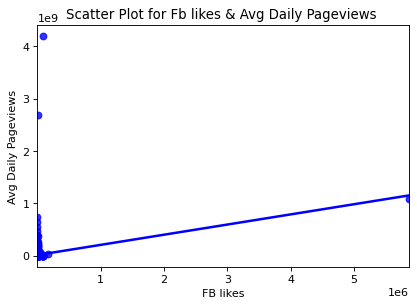

In [14]:
# draw plot
_ = sns.regplot(x='Facebook_likes', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
plt.title('Scatter Plot for Fb likes & Avg Daily Pageviews ')
plt.xlabel('FB likes')
plt.ylabel('Avg Daily Pageviews')
plt.show()

In [15]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ Facebook_likes', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.045
Model:                             OLS   Adj. R-squared:                  0.045
Method:                  Least Squares   F-statistic:                     70.14
Date:                 Sun, 15 May 2022   Prob (F-statistic):           1.26e-16
Time:                         16:32:22   Log-Likelihood:                -29879.
No. Observations:                 1483   AIC:                         5.976e+04
Df Residuals:                     1481   BIC:                         5.977e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.479e+07   3.54e+

###    Standardized Residuals

把殘差值標準化

In [49]:
# studentized residual
print("Standardized Residuals \n")
st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
SD = data1[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)


Standardized Residuals 

[-4.23453228 -3.32288152 -0.2743621  ... -0.08741999  0.03225947
 -0.06945767]
mu =  -7.279293009893724e-05
sigma =  1.0156243106353369


### Normal test

#### H0: Errors are normally distributed <br>
#### H1: Errors are not normally distributed.

### QQ-plot and Histogram

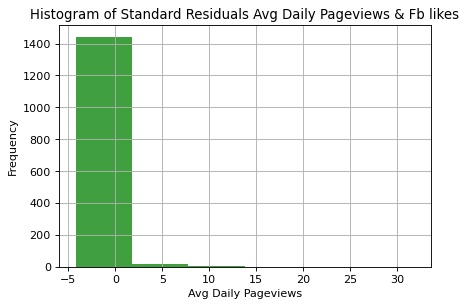

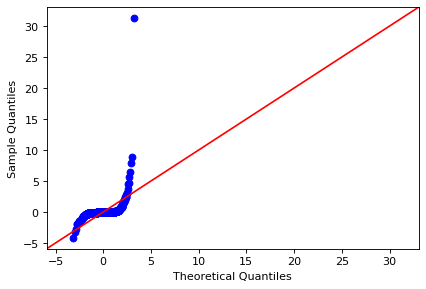

In [50]:
counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Avg Daily Pageviews')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Residuals Avg Daily Pageviews & Fb likes')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()
fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

#### Shapiro Test

In [51]:
print('Shapiro Test')
stat, p = stats.shapiro(SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro Test
Statistics=0.163, p=0.000


Since pvalue is smaller than alpha(0.05), H0 is rejected. Errors are not normally distributed.

### Chi test

In [52]:
chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
print(chi2_pval)

Chi-squared test: statistics = 4646.3374, p-value = 0.0000
Critical value = 7.8147 (defree of freedom = 3)
0.0


### H0: Homoscedasticity <br>
### H1: Heteroscedasticity

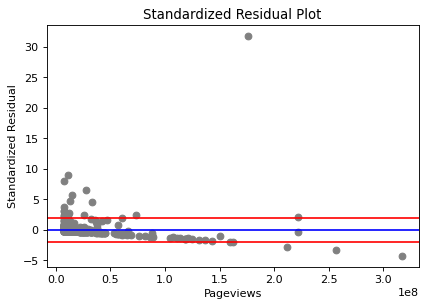

In [53]:

y_pre = data1[:, 2]
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Pageviews')
plt.ylabel('Standardized Residual')
plt.show()

The result seems to be Homoscedasticity. The spread of data points doesn't change much.

### Runs test

測試independence <br>

#### H0: Randomness exists 
#### H1: Randomness does not exist.

In [54]:
SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
  
print('p_value for Z-statistic= ', Z_pval)

runs =  668
n1 =  733
n2 =  733
runs_exp =  734.0
stan_dev =  19.137654750557495
z =  -3.448698435636549
pval_z =  0.0005632954101045788
p_value for Z-statistic=  0.0005632954101045788


Since pvalue is smaller than alpha(0.05), H0 is rejected. Randomness doen't exist.

## Outliers

當error >2 or <-2 ,可以當成outliers

In [55]:
fb_c = pd.DataFrame(SD,columns = ['SD'])
filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
print("Outliers by SD = \n")
print(fb_c['SD'].loc[filter])

Outliers by SD = 

0       -4.234532
1       -3.322882
3        2.077920
4       -2.712810
5       31.761171
6       -2.044192
27       2.464893
34       2.028627
66       4.547171
82       6.488887
88       2.494382
162      5.669484
194      4.772354
208      2.802030
227      9.065810
248      2.432257
431      3.802947
610      2.210936
611      3.029385
632      7.973511
751      2.412966
753      3.116132
1152     2.139694
Name: SD, dtype: float64


### Influential Observation

足以大幅影響回歸線斜率的點

In [56]:
print("\nInfluential Observations \n")
x_data = fb['Facebook_likes'].values
y_data = fb['Avg_Daily_Pageviews'].values
cov_mat1 = np.cov(y_data, x_data)
x_data_bar = x_data.mean()
data_nobs = len(x_data)
h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
print(h_val)
fb_h = pd.DataFrame(h_val,columns = ['hi'])
filter = (fb_h['hi'] > 6 / data_nobs )
print("Influential Observations by hi = \n")
print(fb_h['hi'].loc[filter])


Influential Observations 

[0.1446569  0.09354478 0.06888408 ... 0.00072473 0.00072473 0.00072473]
Influential Observations by hi = 

0     0.144657
1     0.093545
2     0.068884
3     0.068884
4     0.062536
5     0.042122
6     0.035445
7     0.034294
8     0.030418
9     0.027285
10    0.024807
11    0.022588
12    0.020171
13    0.019057
14    0.018347
15    0.018223
16    0.018018
17    0.016574
18    0.015722
19    0.014705
20    0.013802
21    0.009873
22    0.009635
23    0.009577
24    0.009228
25    0.008089
26    0.006982
27    0.006450
28    0.005696
29    0.005139
30    0.004995
31    0.004714
32    0.004518
33    0.004518
34    0.004291
35    0.004291
36    0.004198
37    0.004124
Name: hi, dtype: float64


### Stdandard errors


In [44]:
s2_e = fb_result.mse_resid
print('MSE: ', s2_e)
s_e = fb_result.mse_resid ** 0.5
print('Standard errors: ', s_e)

MSE:  1.7564598563166072e+16
Standard errors:  132531500.26754421


### Coefficient of correlation (and determination)


In [45]:
SSR = fb_result.ssr
# SST = SSR + SSE
R2 = fb_result.rsquared
print("SSR = ", SSR)
print("R2 = ", R2)

SSR =  2.5995605873485787e+19
R2 =  0.058303141155683136


### Testing Coefficient of correlation
H0: r = 0 <br>
H1: r $\neq$ 0.

In [32]:
cor_mat = np.corrcoef(fb[['Avg_Daily_Pageviews', 'Facebook_likes']].values, rowvar = False)
n = fb['Avg_Daily_Pageviews'].shape[0]
# print(n)
r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

r =  0.21264984909255957
t_critical =  1.961567075831078
t =  8.37511814215767
p_value =  1.262885740338516e-16


## Twitter_visitors

In [20]:
fb = df[df["Twitter_mentions"].str.contains("-")==False]
fb = fb[['Avg_Daily_Pageviews','Twitter_mentions']]
fb.reset_index(inplace = True, drop = True)
fb.dropna(inplace=True)
fb['Twitter_mentions'] = fb['Twitter_mentions'].apply(value_to_int)
fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
display(fb)

,Avg_Daily_Pageviews,Twitter_mentions
1,4192159833,11200
2,2679159025,16500
3,1082985733,64400
4,383352336,1110
5,712760,12
...,...,...
2178,41390,85
2179,34177,3
2180,28566,27
2181,51010,15


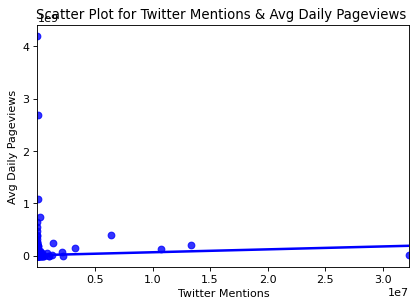

In [21]:
# draw plot
_ = sns.regplot(x='Twitter_mentions', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
plt.title('Scatter Plot for Twitter Mentions & Avg Daily Pageviews ')
plt.xlabel('Twitter Mentions')
plt.ylabel('Avg Daily Pageviews')
plt.show()

In [22]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ Twitter_mentions', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     3.141
Date:                 Tue, 10 May 2022   Prob (F-statistic):             0.0765
Time:                         01:39:04   Log-Likelihood:                -41861.
No. Observations:                 2093   AIC:                         8.373e+04
Df Residuals:                     2091   BIC:                         8.374e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.17e+07   

###    Standardized Residuals

把殘差值標準化

In [23]:
# studentized residual
print("Standardized Residuals \n")
st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
SD = data1[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)


Standardized Residuals 

[35.58668298 22.70662756  9.11653128 ... -0.09936567 -0.09917404
 -0.09945033]
mu =  -0.0006101790414824634
sigma =  1.0013331415824611


### Normal test

#### H0: Errors are normally distributed <br>
#### H1: Errors are not normally distributed.

### QQ-plot and Histogram

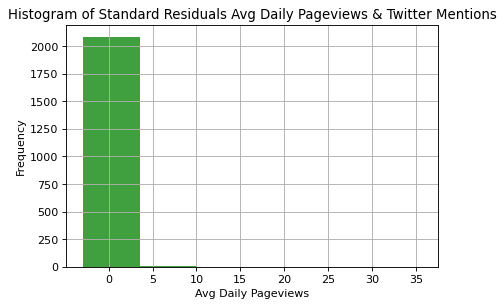

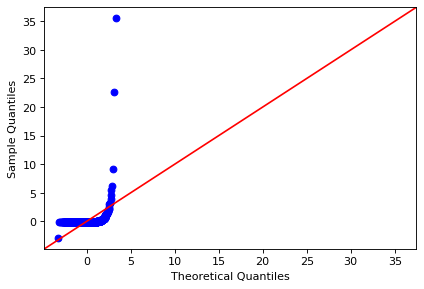

In [24]:
counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Avg Daily Pageviews')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Residuals Avg Daily Pageviews & Twitter Mentions')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()
fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

#### Shapiro Test

In [25]:
print('Shapiro Test')
stat, p = stats.shapiro(SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro Test
Statistics=0.063, p=0.000


Since pvalue is smaller than alpha(0.05), H0 is rejected. Errors are not normally distributed.

### Chi test

In [26]:
chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
print(chi2_pval)

Chi-squared test: statistics = 8171.9276, p-value = 0.0000
Critical value = 7.8147 (defree of freedom = 3)
0.0


### H0: Homoscedasticity <br>
### H1: Heteroscedasticity

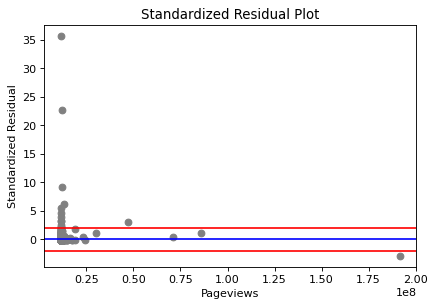

In [27]:

y_pre = data1[:, 2]
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Pageviews')
plt.ylabel('Standardized Residual')
plt.show()

The result seems to be Homoscedasticity. The spread of data points doesn't change much.

### Runs test

測試independence <br>

#### H0: Randomness exists 
#### H1: Randomness does not exist.

In [28]:
SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
  
print('p_value for Z-statistic= ', Z_pval)

runs =  576
n1 =  1047
n2 =  1046
runs_exp =  1047.4997611084568
stan_dev =  22.86918541631109
z =  -20.61725210256798
pval_z =  1.9216768858845797e-94
p_value for Z-statistic=  1.9216768858845797e-94


Since pvalue is smaller than alpha(0.05), H0 is rejected. Randomness doen't exist.

## Outliers

當error >2 or <-2 ,可以當成outliers

In [29]:
fb_c = pd.DataFrame(SD,columns = ['SD'])
filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
print("Outliers by SD = \n")
print(fb_c['SD'].loc[filter])

Outliers by SD = 

0      35.586683
1      22.706628
2       9.116531
3       3.163724
6       3.281628
26      3.040741
84      2.208246
138     5.426236
174    -2.872730
249     4.584161
490     6.200231
491     2.573605
492     2.096857
493     2.038437
512     3.913272
Name: SD, dtype: float64


### Influential Observation

足以大幅影響回歸線斜率的點

In [31]:
print("\nInfluential Observations \n")
x_data = fb['Twitter_mentions'].values
y_data = fb['Avg_Daily_Pageviews'].values
cov_mat1 = np.cov(y_data, x_data)
x_data_bar = x_data.mean()
data_nobs = len(x_data)
h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
print(h_val)
fb_h = pd.DataFrame(h_val,columns = ['hi'])
filter = (fb_h['hi'] > 6 / data_nobs )
print("Influential Observations by hi = \n")
print(fb_h['hi'].loc[filter])


Influential Observations 

[0.0004784  0.0004782  0.00047819 ... 0.00047896 0.00047896 0.00047895]
Influential Observations by hi = 

15      0.008107
17      0.125970
26      0.029435
93      0.003534
174     0.743298
394     0.003962
1061    0.081580
Name: hi, dtype: float64


### Stdandard errors


In [32]:
s2_e = fb_result.mse_resid
print('MSE: ', s2_e)
s_e = fb_result.mse_resid ** 0.5
print('Standard errors: ', s_e)

MSE:  1.3805996447682924e+16
Standard errors:  117498921.04901612


### Coefficient of correlation (and determination)


In [33]:
SSR = fb_result.ssr
# SST = SSR + SSE
R2 = fb_result.rsquared
print("SSR = ", SSR)
print("R2 = ", R2)

SSR =  2.8868338572104995e+19
R2 =  0.0015000192497816034


### Testing Coefficient of correlation
H0: r = 0 <br>
H1: r $\neq$ 0.

In [35]:
cor_mat = np.corrcoef(fb[['Avg_Daily_Pageviews', 'Twitter_mentions']].values, rowvar = False)
n = fb['Avg_Daily_Pageviews'].shape[0]
# print(n)
r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

r =  0.038730081974894234
t_critical =  1.961099145538133
t =  1.7723578053112499
p_value =  0.07648076264124146


## Google_visitors

In [106]:
fb = df[df["Google_pluses"].str.contains("-")==False]
fb = fb[['Avg_Daily_Pageviews','Google_pluses','Website']]
fb['Google_pluses'] = fb['Google_pluses'].apply(value_to_int)
fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
fb.dropna(inplace=True)
fb.sort_values(by=['Google_pluses'], ascending = False, inplace=True)
fb.reset_index(inplace = True, drop = True)
#fb
display(fb)

,Avg_Daily_Pageviews,Google_pluses,Website
0,2.679159e+09,19300000,www.youtube.com
1,4.192160e+09,11700000,www.google.com
2,3.240750e+05,11700000,www.blogspot.co.za
3,6.631300e+04,11700000,www.blogspot.si
4,1.571130e+05,11700000,www.blogspot.rs
...,...,...,...
2802,1.512693e+06,1,www.unisa.ac.za
2803,1.815970e+05,1,www.boxden.com
2804,3.604824e+06,1,www.thevideo.me
2805,5.047000e+03,1,www.puntlandpost.net


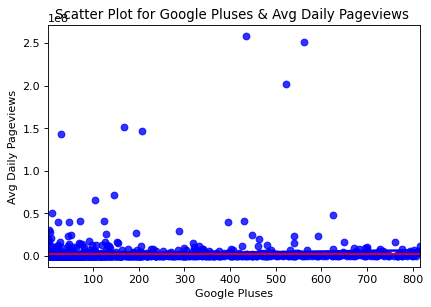

In [96]:
# draw plot
_ = sns.regplot(x='Google_pluses', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
#plt.plot(x=fb['Google_pluses'],y=fb['Avg_Daily_Pageviews'].mean())
plt.axhline(y=fb['Avg_Daily_Pageviews'].mean(), color='r', linestyle='-')
plt.title('Scatter Plot for Google Pluses & Avg Daily Pageviews ')
plt.xlabel('Google Pluses')
plt.ylabel('Avg Daily Pageviews')
plt.show()

In [97]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ Google_pluses', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.011
Method:                  Least Squares   F-statistic:                     20.63
Date:                 Mon, 16 May 2022   Prob (F-statistic):           5.94e-06
Time:                         15:51:10   Log-Likelihood:                -32043.
No. Observations:                 1807   AIC:                         6.409e+04
Df Residuals:                     1805   BIC:                         6.410e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.145e+06   3.51e+05 

###    Standardized Residuals

把殘差值標準化

In [98]:
# studentized residual
print("Standardized Residuals \n")
st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
SD = data1[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)


Standardized Residuals 

[ 0.38342584 -0.08380648 -0.25259468 ...  0.2017184  -0.09423833
 -0.09154085]
mu =  -1.6760314916551765e-05
sigma =  1.0003631786280356


The result seems to be Homoscedasticity. The spread of data points doesn't change much.

### Runs test

測試independence <br>

#### H0: Randomness exists 
#### H1: Randomness does not exist.

In [99]:
SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
  
print('p_value for Z-statistic= ', Z_pval)

runs =  657
n1 =  904
n2 =  903
runs_exp =  904.4997232982845
stan_dev =  21.24851959245309
z =  -11.647857264662797
pval_z =  2.353009861328476e-31
p_value for Z-statistic=  2.353009861328476e-31


Since pvalue is smaller than alpha(0.05), H0 is rejected. Randomness doen't exist.

## Outliers

當error >2 or <-2 ,可以當成outliers

In [100]:
fb_c = pd.DataFrame(SD,columns = ['SD'])
filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
print("Outliers by SD = \n")
print(fb_c['SD'].loc[filter])
out_index = fb_c['SD'].loc[filter].index
out_index

Outliers by SD = 

93       3.497290
113     20.275388
139     16.199390
205     20.895935
209      2.997714
241      2.936527
343      2.149431
425     11.837985
448      2.044216
487     12.280162
532      5.686640
589      3.209435
648      5.246117
757      3.197899
863      3.138677
983     11.685018
1068     3.178061
1285     3.991047
1461     2.185201
1546     2.349435
Name: SD, dtype: float64


Int64Index([  93,  113,  139,  205,  209,  241,  343,  425,  448,  487,  532,
             589,  648,  757,  863,  983, 1068, 1285, 1461, 1546],
           dtype='int64')

### Influential Observation

足以大幅影響回歸線斜率的點

In [101]:
print("\nInfluential Observations \n")
x_data = fb['Google_pluses'].values
y_data = fb['Avg_Daily_Pageviews'].values
cov_mat1 = np.cov(y_data, x_data)
x_data_bar = x_data.mean()
data_nobs = len(x_data)
h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
print(h_val)
fb_h = pd.DataFrame(h_val,columns = ['hi'])
filter = (fb_h['hi'] > 6 / data_nobs )
print("Influential Observations by hi = \n")
print(fb_h['hi'].loc[filter])
influ_index = fb_h['hi'].loc[filter].index
influ_index


Influential Observations 

[0.00693045 0.00685513 0.00679893 ... 0.00082628 0.00082628 0.00082628]
Influential Observations by hi = 

0      0.006930
1      0.006855
2      0.006799
3      0.006780
4      0.006780
         ...   
100    0.003414
101    0.003414
102    0.003402
103    0.003376
104    0.003351
Name: hi, Length: 105, dtype: float64


Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             95,  96,  97,  98,  99, 100, 101, 102, 103, 104],
           dtype='int64', length=105)

### Stdandard errors


In [102]:
s2_e = fb_result.mse_resid
print('MSE: ', s2_e)
s_e = fb_result.mse_resid ** 0.5
print('Standard errors: ', s_e)

MSE:  148065451360549.44
Standard errors:  12168214.797600733


### Coefficient of correlation (and determination)


In [103]:
SSR = fb_result.ssr
# SST = SSR + SSE
R2 = fb_result.rsquared
print("SSR = ", SSR)
print("R2 = ", R2)

SSR =  2.672581397057917e+17
R2 =  0.011300491557948211


### Testing Coefficient of correlation
H0: r = 0 <br>
H1: r $\neq$ 0.

In [104]:
cor_mat = np.corrcoef(fb[['Avg_Daily_Pageviews', 'Google_pluses']].values, rowvar = False)
n = fb['Avg_Daily_Pageviews'].shape[0]
# print(n)
r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

r =  0.10630377019630344
t_critical =  1.9612791289866973
t =  4.542083476252226
p_value =  5.9387599509752996e-06


In [105]:
#new fb
cross = list(set(influ_index).intersection(out_index))
fb.drop(cross, axis=0, inplace=True)
display(fb)
# draw plot
_ = sns.regplot(x='Google_pluses', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
plt.title('Scatter Plot for Google Pluses & Avg Daily Pageviews ')
plt.xlabel('Google Pluses')
plt.ylabel('Avg Daily Pageviews')
plt.show()

KeyError: '[93] not found in axis'

In [73]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ Google_pluses', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.011
Method:                  Least Squares   F-statistic:                     30.55
Date:                 Sun, 15 May 2022   Prob (F-statistic):           3.56e-08
Time:                         16:44:13   Log-Likelihood:                -52535.
No. Observations:                 2783   AIC:                         1.051e+05
Df Residuals:                     2781   BIC:                         1.051e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.331e+06   7.35e+05 

## LinkedIn_visitors

In [50]:
fb = df[df["LinkedIn_mentions"].str.contains("-")==False]
fb = fb[['Avg_Daily_Pageviews','LinkedIn_mentions']]
fb.reset_index(inplace = True, drop = True)
fb.dropna(inplace=True)
fb['LinkedIn_mentions'] = fb['LinkedIn_mentions'].apply(value_to_int)
fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
display(fb)

,Avg_Daily_Pageviews,LinkedIn_mentions
1,4192159833,1670
2,2679159025,60000
3,1082985733,6230
4,383352336,7500
5,712760,146
...,...,...
2161,41390,17
2162,34177,1
2163,1009,86
2164,28566,5


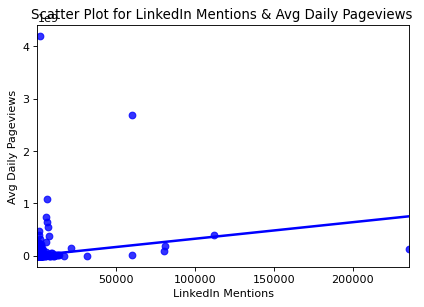

In [51]:
# draw plot
_ = sns.regplot(x='LinkedIn_mentions', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
plt.title('Scatter Plot for LinkedIn Mentions & Avg Daily Pageviews ')
plt.xlabel('LinkedIn Mentions')
plt.ylabel('Avg Daily Pageviews')
plt.show()

In [52]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ LinkedIn_mentions', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.032
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     67.94
Date:                 Tue, 10 May 2022   Prob (F-statistic):           2.95e-16
Time:                         01:43:32   Log-Likelihood:                -41595.
No. Observations:                 2081   AIC:                         8.319e+04
Df Residuals:                     2079   BIC:                         8.320e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.04e+07

###    Standardized Residuals

把殘差值標準化

In [53]:
# studentized residual
print("Standardized Residuals \n")
st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
SD = data1[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)


Standardized Residuals 

[36.00404726 21.79709266  9.07855812 ... -0.09197429 -0.08953557
 -0.08958315]
mu =  -0.0013413723556816482
sigma =  1.0144791165997562


### Normal test

#### H0: Errors are normally distributed <br>
#### H1: Errors are not normally distributed.

### QQ-plot and Histogram

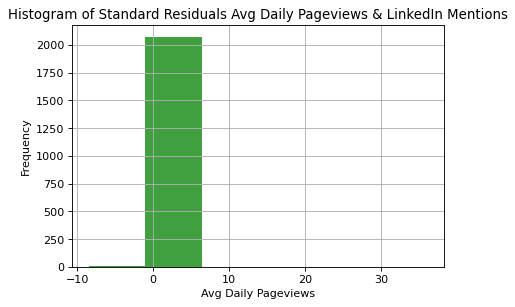

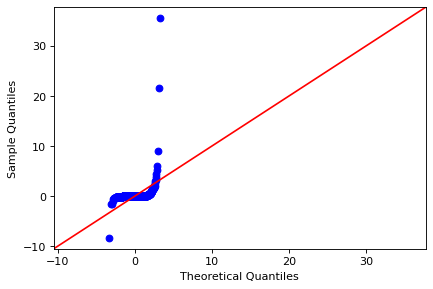

In [54]:
counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Avg Daily Pageviews')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Residuals Avg Daily Pageviews & LinkedIn Mentions')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()
fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

#### Shapiro Test

In [55]:
print('Shapiro Test')
stat, p = stats.shapiro(SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro Test
Statistics=0.071, p=0.000


Since pvalue is smaller than alpha(0.05), H0 is rejected. Errors are not normally distributed.

### Chi test

In [56]:
chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
print(chi2_pval)

Chi-squared test: statistics = 7900.4359, p-value = 0.0000
Critical value = 7.8147 (defree of freedom = 3)
0.0


### H0: Homoscedasticity <br>
### H1: Heteroscedasticity

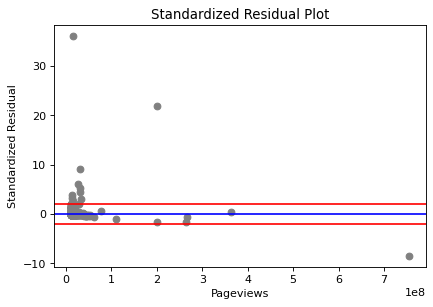

In [57]:

y_pre = data1[:, 2]
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Pageviews')
plt.ylabel('Standardized Residual')
plt.show()

The result seems to be Homoscedasticity. The spread of data points doesn't change much.

### Runs test

測試independence <br>

#### H0: Randomness exists 
#### H1: Randomness does not exist.

In [58]:
SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
  
print('p_value for Z-statistic= ', Z_pval)

runs =  710
n1 =  1041
n2 =  1040
runs_exp =  1041.4997597308986
stan_dev =  22.80350059834276
z =  -14.537231172085495
pval_z =  7.038237697701136e-48
p_value for Z-statistic=  7.038237697701136e-48


Since pvalue is smaller than alpha(0.05), H0 is rejected. Randomness doen't exist.

## Outliers

當error >2 or <-2 ,可以當成outliers

In [59]:
fb_c = pd.DataFrame(SD,columns = ['SD'])
filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
print("Outliers by SD = \n")
print(fb_c['SD'].loc[filter])

Outliers by SD = 

0      36.004047
1      21.797093
2       9.078558
3       3.012028
6       3.300736
19     -8.461189
83      2.090937
139     5.333131
242     4.470688
492     6.156856
493     2.565821
494     2.124286
495     2.066873
514     3.944720
Name: SD, dtype: float64


### Influential Observation

足以大幅影響回歸線斜率的點

In [60]:
print("\nInfluential Observations \n")
x_data = fb['LinkedIn_mentions'].values
y_data = fb['Avg_Daily_Pageviews'].values
cov_mat1 = np.cov(y_data, x_data)
x_data_bar = x_data.mean()
data_nobs = len(x_data)
h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
print(h_val)
fb_h = pd.DataFrame(h_val,columns = ['hi'])
filter = (fb_h['hi'] > 6 / data_nobs )
print("Influential Observations by hi = \n")
print(fb_h['hi'].loc[filter])


Influential Observations 

[0.00049181 0.03874921 0.00081865 ... 0.00048401 0.00048508 0.00048509]
Influential Observations by hi = 

1       0.038749
8       0.070448
17      0.005113
19      0.602273
28      0.135188
115     0.039137
397     0.010954
1073    0.069579
1683    0.003244
Name: hi, dtype: float64


### Stdandard errors


In [61]:
s2_e = fb_result.mse_resid
print('MSE: ', s2_e)
s_e = fb_result.mse_resid ** 0.5
print('Standard errors: ', s_e)

MSE:  1.3462793988311132e+16
Standard errors:  116029280.73685165


### Coefficient of correlation (and determination)


In [62]:
SSR = fb_result.ssr
# SST = SSR + SSE
R2 = fb_result.rsquared
print("SSR = ", SSR)
print("R2 = ", R2)

SSR =  2.7989148701698843e+19
R2 =  0.03164472908967053


### Testing Coefficient of correlation
H0: r = 0 <br>
H1: r $\neq$ 0.

In [63]:
cor_mat = np.corrcoef(fb[['Avg_Daily_Pageviews', 'LinkedIn_mentions']].values, rowvar = False)
n = fb['Avg_Daily_Pageviews'].shape[0]
# print(n)
r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

r =  0.17788965425136646
t_critical =  1.961105701444812
t =  8.242530735740186
p_value =  2.9494093923960474e-16


## Pinterest_visitors

In [64]:
fb = df[df["Pinterest_pins"].str.contains("-")==False]
fb = fb[['Avg_Daily_Pageviews','Pinterest_pins']]
fb.reset_index(inplace = True, drop = True)
fb.dropna(inplace=True)
fb['Pinterest_pins'] = fb['Pinterest_pins'].apply(value_to_int)
fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
display(fb)

,Avg_Daily_Pageviews,Pinterest_pins
0,4192159833,10800
1,2679159025,47
2,1082985733,4150
3,383352336,433
4,24690228,16
...,...,...
256,969149,1
257,887104,1
258,1702420,5
259,646099,5


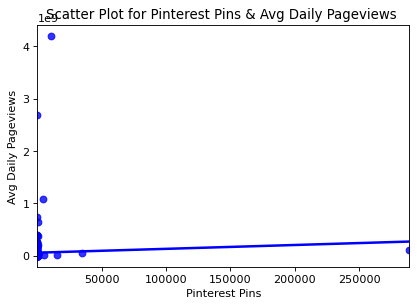

In [65]:
# draw plot
_ = sns.regplot(x='Pinterest_pins', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
plt.title('Scatter Plot for Pinterest Pins & Avg Daily Pageviews ')
plt.xlabel('Pinterest Pins')
plt.ylabel('Avg Daily Pageviews')
plt.show()

In [66]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ Pinterest_pins', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.4375
Date:                 Tue, 10 May 2022   Prob (F-statistic):              0.509
Time:                         01:45:48   Log-Likelihood:                -5462.5
No. Observations:                  260   AIC:                         1.093e+04
Df Residuals:                      258   BIC:                         1.094e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5.919e+07   2.01e+

###    Standardized Residuals

把殘差值標準化

In [67]:
# studentized residual
print("Standardized Residuals \n")
st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
SD = data1[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)


Standardized Residuals 

[ 1.27868875e+01  8.11719462e+00  3.16262663e+00  1.00335061e+00
 -1.06915296e-01  1.04722679e+00 -1.53670884e-01  3.65241999e-02
 -1.16556382e-01  3.02846242e-01  2.35539816e-01  4.55246837e-01
 -1.67871660e-01  4.37463034e-02 -3.32197459e-02  2.63841641e-01
  1.05366069e+00 -1.42055152e-01  5.94982619e-02  2.70511933e-01
 -2.61429980e-02 -1.12552840e-01  3.01426608e-02 -1.26469923e-01
  3.13407058e-01  6.56339173e-01 -1.04005587e-01 -1.59086148e-01
 -3.55685911e-02 -1.68205291e-01 -1.65636253e-01 -1.52424951e-01
 -3.06361865e-03 -1.07616557e-01 -1.65599848e-01 -1.36671708e-01
 -1.09579724e-01 -1.50173454e-01 -1.73320931e-01 -1.76997671e-01
 -1.80771974e-01  1.82672741e+00 -3.66906449e+00 -1.06074945e-01
 -1.51698610e-01  3.81793578e-01 -1.47055200e-01 -1.20196803e-01
 -1.75642721e-01 -1.41004459e-01 -1.06329303e-01 -4.28935846e-02
  7.26783402e-02 -1.39417898e-01 -1.76269142e-01  3.01876022e-02
 -1.79360298e-01 -1.72907868e-01 -1.78917737e-01  5.20097997e-01


### Normal test

#### H0: Errors are normally distributed <br>
#### H1: Errors are not normally distributed.

### QQ-plot and Histogram

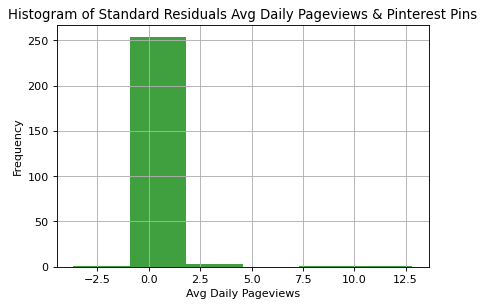

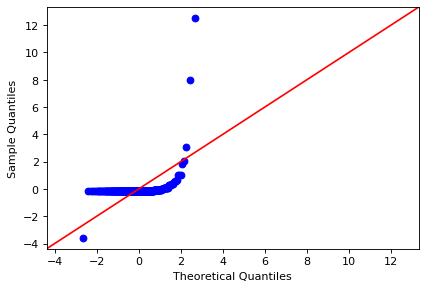

In [68]:
counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Avg Daily Pageviews')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Residuals Avg Daily Pageviews & Pinterest Pins')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()
fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

#### Shapiro Test

In [69]:
print('Shapiro Test')
stat, p = stats.shapiro(SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro Test
Statistics=0.185, p=0.000


Since pvalue is smaller than alpha(0.05), H0 is rejected. Errors are not normally distributed.

### Chi test

In [70]:
chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
print(chi2_pval)

Chi-squared test: statistics = 950.1860, p-value = 0.0000
Critical value = 7.8147 (defree of freedom = 3)
1.150859582663572e-205


### H0: Homoscedasticity <br>
### H1: Heteroscedasticity

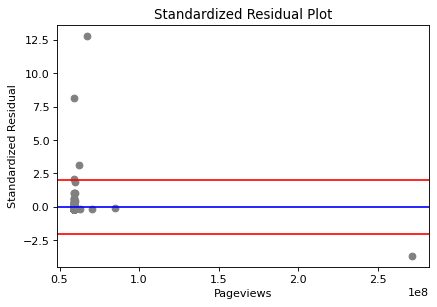

In [71]:

y_pre = data1[:, 2]
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Pageviews')
plt.ylabel('Standardized Residual')
plt.show()

The result seems to be Homoscedasticity. The spread of data points doesn't change much.

### Runs test

測試independence <br>

#### H0: Randomness exists 
#### H1: Randomness does not exist.

In [72]:
SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
  
print('p_value for Z-statistic= ', Z_pval)

runs =  90
n1 =  130
n2 =  130
runs_exp =  131.0
stan_dev =  8.04667849171537
z =  -5.095270059840519
pval_z =  3.4824446815557084e-07
p_value for Z-statistic=  3.4824446815557084e-07


Since pvalue is smaller than alpha(0.05), H0 is rejected. Randomness doen't exist.

## Outliers

當error >2 or <-2 ,可以當成outliers

In [73]:
fb_c = pd.DataFrame(SD,columns = ['SD'])
filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
print("Outliers by SD = \n")
print(fb_c['SD'].loc[filter])

Outliers by SD = 

0      12.786888
1       8.117195
2       3.162627
42     -3.669064
105     2.113860
Name: SD, dtype: float64


### Influential Observation

足以大幅影響回歸線斜率的點

In [74]:
print("\nInfluential Observations \n")
x_data = fb['Pinterest_pins'].values
y_data = fb['Avg_Daily_Pageviews'].values
cov_mat1 = np.cov(y_data, x_data)
x_data_bar = x_data.mean()
data_nobs = len(x_data)
h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
print(h_val)
fb_h = pd.DataFrame(h_val,columns = ['hi'])
filter = (fb_h['hi'] > 6 / data_nobs )
print("Influential Observations by hi = \n")
print(fb_h['hi'].loc[filter])


Influential Observations 

[0.00488826 0.00386805 0.00393496 0.0038574  0.00386906 0.00386942
 0.00386952 0.00386764 0.00386956 0.00386841 0.00386919 0.00385308
 0.00386956 0.00386867 0.00386877 0.00386952 0.0038661  0.00386956
 0.00386466 0.00386949 0.00386956 0.00386956 0.00386952 0.00386956
 0.00386949 0.00386629 0.00386956 0.00386933 0.00386949 0.00386956
 0.0038688  0.00386916 0.00386949 0.00386926 0.00386933 0.00386952
 0.00386936 0.00386956 0.00386956 0.00386946 0.00386956 0.00385544
 0.98105174 0.01717813 0.00386956 0.00386825 0.0038687  0.00386952
 0.00386952 0.0038689  0.00386114 0.00385195 0.00386669 0.00386956
 0.00386942 0.00386789 0.00386952 0.00386956 0.00386949 0.00386949
 0.00386949 0.00386946 0.00386295 0.00386726 0.00386952 0.00386956
 0.00386956 0.00386949 0.00386796 0.00386956 0.00386952 0.00386952
 0.00386956 0.00386956 0.00386751 0.00386949 0.00402693 0.00386939
 0.00386767 0.00386952 0.00386952 0.00386936 0.00386956 0.00386952
 0.00386956 0.00386956 0.00386956 

### Stdandard errors


In [75]:
s2_e = fb_result.mse_resid
print('MSE: ', s2_e)
s_e = fb_result.mse_resid ** 0.5
print('Standard errors: ', s_e)

MSE:  1.0458107825083723e+17
Standard errors:  323389978.5875209


### Coefficient of correlation (and determination)


In [76]:
SSR = fb_result.ssr
# SST = SSR + SSE
R2 = fb_result.rsquared
print("SSR = ", SSR)
print("R2 = ", R2)

SSR =  2.6981918188716007e+19
R2 =  0.0016929817611738285


### Testing Coefficient of correlation
H0: r = 0 <br>
H1: r $\neq$ 0.

In [77]:
cor_mat = np.corrcoef(fb[['Avg_Daily_Pageviews', 'Pinterest_pins']].values, rowvar = False)
n = fb['Avg_Daily_Pageviews'].shape[0]
# print(n)
r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

r =  0.04114585958724907
t_critical =  1.9692013862332611
t =  0.6614605239427631
p_value =  0.5089073131878672


## StumbleUpon_visitors

In [78]:
fb = df[df["StumbleUpon_views"].str.contains("-")==False]
fb = fb[['Avg_Daily_Pageviews','StumbleUpon_views']]
fb.reset_index(inplace = True, drop = True)
fb.dropna(inplace=True)
fb['StumbleUpon_views'] = fb['StumbleUpon_views'].apply(value_to_int)
fb['Avg_Daily_Pageviews'] = fb['Avg_Daily_Pageviews'].apply(value_to_int)
display(fb)

,Avg_Daily_Pageviews,StumbleUpon_views
1,4192159833,246000
2,2679159025,329000
3,1082985733,23100
4,383352336,68900
5,712760,8
...,...,...
1734,56111,216
1735,61213,1
1736,10600,1
1737,1009,1


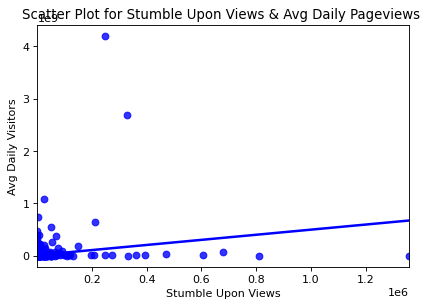

In [79]:
# draw plot
_ = sns.regplot(x='StumbleUpon_views', y= 'Avg_Daily_Pageviews', data = fb, color = 'b', ci = None)
plt.title('Scatter Plot for Stumble Upon Views & Avg Daily Pageviews ')
plt.xlabel('Stumble Upon Views')
plt.ylabel('Avg Daily Visitors')
plt.show()

In [80]:
# Fit regression model 
fb_result = smf.ols('Avg_Daily_Pageviews~ StumbleUpon_views', data=fb).fit()
# Inspect the results
print(fb_result.summary())

b1 = fb_result.params[1]
b0 = fb_result.params[0]

print(f"\nEstimated model: y = {b0:.4f} + {b1:.4f} x")
print(f"The coefficients are {b0:.4f} and {b1:.4f}")

                             OLS Regression Results                            
Dep. Variable:     Avg_Daily_Pageviews   R-squared:                       0.037
Model:                             OLS   Adj. R-squared:                  0.037
Method:                  Least Squares   F-statistic:                     64.82
Date:                 Tue, 10 May 2022   Prob (F-statistic):           1.54e-15
Time:                         01:47:50   Log-Likelihood:                -33852.
No. Observations:                 1685   AIC:                         6.771e+04
Df Residuals:                     1683   BIC:                         6.772e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.237e+07

###    Standardized Residuals

把殘差值標準化

In [81]:
# studentized residual
print("Standardized Residuals \n")
st1, data1, ss3 = sso.summary_table(fb_result, alpha=0.05)
SD = data1[:, 10]
mu = np.mean(SD)
sigma = np.std(SD)
print(SD)
print('mu = ', mu)
print('sigma = ', sigma)


Standardized Residuals 

[31.79417103 19.73330486  8.2431845  ... -0.09615118 -0.0962258
 -0.09607886]
mu =  -0.0009995187443320994
sigma =  1.012554785477333


### Normal test

#### H0: Errors are normally distributed <br>
#### H1: Errors are not normally distributed.

### QQ-plot and Histogram

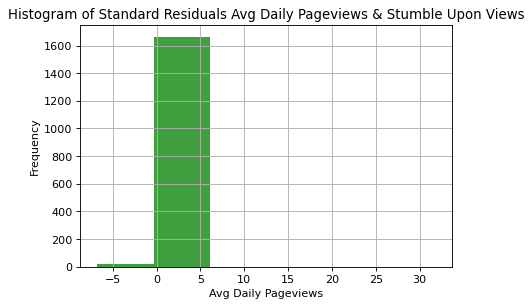

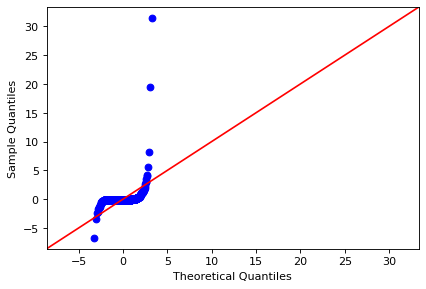

In [82]:
counts, bins, patches = plt.hist(SD, 6, density=False, facecolor='g', alpha=0.75)
plt.xlabel('Avg Daily Pageviews')
plt.ylabel('Frequency')
plt.title('Histogram of Standard Residuals Avg Daily Pageviews & Stumble Upon Views')
plt.grid(True)
bin_centers = [np.mean(k) for k in zip(bins[:-1], bins[1:])]
plt.show()
fig = sm.qqplot(SD, stats.norm, fit=True, line='45')

#### Shapiro Test

In [83]:
print('Shapiro Test')
stat, p = stats.shapiro(SD)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Shapiro Test
Statistics=0.097, p=0.000


Since pvalue is smaller than alpha(0.05), H0 is rejected. Errors are not normally distributed.

### Chi test

In [84]:
chi2_pval = Chi_Square_for_Normality(SD, 6, 0.05) 
print(chi2_pval)

Chi-squared test: statistics = 6116.3647, p-value = 0.0000
Critical value = 7.8147 (defree of freedom = 3)
0.0


### H0: Homoscedasticity <br>
### H1: Heteroscedasticity

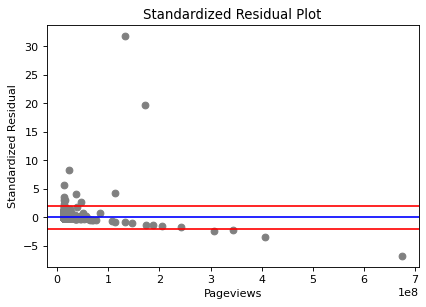

In [85]:

y_pre = data1[:, 2]
plt.plot(y_pre, SD, 'o', color = 'gray')
plt.axhline(y=0, color = 'blue')
plt.axhline(y=2, color = 'red')
plt.axhline(y=-2, color = 'red')
plt.title('Standardized Residual Plot')
plt.xlabel('Pageviews')
plt.ylabel('Standardized Residual')
plt.show()

The result seems to be Homoscedasticity. The spread of data points doesn't change much.

### Runs test

測試independence <br>

#### H0: Randomness exists 
#### H1: Randomness does not exist.

In [86]:
SD_median = statistics.median(SD)
Z_pval = runsTest(SD, SD_median) 
  
print('p_value for Z-statistic= ', Z_pval)

runs =  532
n1 =  843
n2 =  842
runs_exp =  843.4997032640949
stan_dev =  20.51827368001729
z =  -15.181574635465747
pval_z =  4.684007734857053e-52
p_value for Z-statistic=  4.684007734857053e-52


Since pvalue is smaller than alpha(0.05), H0 is rejected. Randomness doen't exist.

## Outliers

當error >2 or <-2 ,可以當成outliers

In [87]:
fb_c = pd.DataFrame(SD,columns = ['SD'])
filter = (fb_c['SD'] < -2) | (fb_c['SD'] > 2)
print("Outliers by SD = \n")
print(fb_c['SD'].loc[filter])

Outliers by SD = 

0      31.794171
1      19.733305
2       8.243185
3       2.626906
6       2.994315
27      2.992681
118     4.182811
129    -6.775941
145    -2.376210
159    -2.249801
203     4.001713
396    -3.397427
411     5.670328
412     2.346948
432     3.570056
Name: SD, dtype: float64


### Influential Observation

足以大幅影響回歸線斜率的點

In [88]:
print("\nInfluential Observations \n")
x_data = fb['StumbleUpon_views'].values
y_data = fb['Avg_Daily_Pageviews'].values
cov_mat1 = np.cov(y_data, x_data)
x_data_bar = x_data.mean()
data_nobs = len(x_data)
h_val = 1 / data_nobs + (x_data - x_data_bar) ** 2 / (data_nobs - 1) / cov_mat1[1,1]
print(h_val)
fb_h = pd.DataFrame(h_val,columns = ['hi'])
filter = (fb_h['hi'] > 6 / data_nobs )
print("Influential Observations by hi = \n")
print(fb_h['hi'].loc[filter])


Influential Observations 

[0.01330962 0.02363128 0.00065725 ... 0.00060172 0.00060172 0.00060172]
Influential Observations by hi = 

0       0.013310
1       0.023631
104     0.034012
118     0.009689
129     0.405636
135     0.005042
145     0.079849
159     0.100942
186     0.028111
260     0.008477
318     0.009511
388     0.013630
396     0.143038
573     0.023774
754     0.016451
954     0.048556
1638    0.003931
Name: hi, dtype: float64


### Stdandard errors


In [89]:
s2_e = fb_result.mse_resid
print('MSE: ', s2_e)
s_e = fb_result.mse_resid ** 0.5
print('Standard errors: ', s_e)

MSE:  1.6527169520504406e+16
Standard errors:  128558039.50163679


### Coefficient of correlation (and determination)


In [90]:
SSR = fb_result.ssr
# SST = SSR + SSE
R2 = fb_result.rsquared
print("SSR = ", SSR)
print("R2 = ", R2)

SSR =  2.7815226303008915e+19
R2 =  0.037085330446940734


### Testing Coefficient of correlation
H0: r = 0 <br>
H1: r $\neq$ 0.

In [91]:
cor_mat = np.corrcoef(fb[['Avg_Daily_Pageviews', 'StumbleUpon_views']].values, rowvar = False)
n = fb['Avg_Daily_Pageviews'].shape[0]
# print(n)
r_t_value = c_of_c_test(cor_mat[1,0], n,0.05)

r =  0.19257551881519328
t_critical =  1.9613745307057746
t =  8.050988995656223
p_value =  1.5378580538397456e-15
